# Null model of GLM
Essentially what we are doing here is to re-create everything after the individual connectome step and running it a couple times. About 1000. 

1. Find and load the pheno file for the 16p guys
2. Load a single individual connectome
3. Load all connectomes in the order specified by the pheno file
4. Build the GLM and regress the approriate covariates
5. Extract the beta for the group contrast
6. Keep the average beta of the group contrast and go to the next iteration

Sidenotes:
- loading of the connectomes can be done only once
- the only thing that needs to be scrambled is the genetic status information in the pheno file
- therefore the entire GLM process could be relatively quick
- the way the contrasts are set up (only the two groups are considered) means that we need to remove individuals for each run

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time
import patsy
import numpy as np
import pandas as pd
import seaborn as sbn
from scipy import stats
from scipy import io as sio
import pathlib as pal
import sklearn.linear_model as sln
from matplotlib import pyplot as plt

In [3]:
# Paths
root_p = pal.Path('/home/surchs/data/')
pheno16_p = root_p / 'paper_16p22q/pheno/Pheno_16p.csv'
data16_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/individual/'
pheno22_p = root_p / 'paper_16p22q/pheno/Pheno_22q.csv'
data22_p = root_p / 'paper_16p22q/glm/22q/cambridge64/individual/'
temp = 'connectome_{}_cambridge64.mat'
figure_p = root_p / 'paper_16p22q/figures/unclear/'

niak16_delcon_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
niak16_dupcon_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/dup_minus_con/glm_dup_minus_con_cambridge64.mat'
niak22_delcon_p = root_p / 'paper_16p22q/glm/22q/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
niak22_dupcon_p = root_p / 'paper_16p22q/glm/22q/cambridge64/dup_minus_con/glm_dup_minus_con_cambridge64.mat'

monte_carlo_16_p = root_p / 'paper_16p22q/glm/16p_age/monte_carlo_16p_global_shift.npy'
monte_carlo_22_p = root_p / 'paper_16p22q/glm/22q/monte_carlo_22q_global_shift.npy'

In [4]:
pheno16 = pd.read_csv(pheno16_p)
pheno22 = pd.read_csv(pheno22_p)
# Rename the niak column to fname
pheno16.rename(columns={'Unnamed: 0':'fname'}, inplace=True)
pheno22.rename(columns={'Unnamed: 0':'fname'}, inplace=True)
# Get a genetic status column for the 16p
pheno16['genetic_status'] = pheno16.genetic_status_16p.replace({1:'deletion',
                                    2:'control',
                                    3:'duplication'})
# Find the number of subjects
n16 = pheno16.shape[0]
n22 = pheno22.shape[0]

In [5]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

## Load the connectomes

In [6]:
conn16 = np.zeros((n16, 2080))

for rid, row in pheno16.iterrows():
    p = os.path.join(data16_p, temp.format(row['fname']))
    conn16[rid, :] = sio.loadmat(p)['del_minus_con']['connectome'][0][0].squeeze()

In [7]:
conn22 = np.zeros((n22, 2080))

for rid, row in pheno22.iterrows():
    p = os.path.join(data22_p, temp.format(row['fname']))
    conn22[rid, :] = sio.loadmat(p)['del_minus_con']['connectome'][0][0].squeeze()

In [8]:
# Get the connectivity of only the controls
conn16_control = conn16[pheno16.g2==1, :]
conn22_control = conn22[pheno22.g2==1, :]

### Prove that we find the same stuff as with niak

In [9]:
# Contrast 1: del vs con w/o dup. Find the dup and exclude them
dup16_mask = pheno16.genetic_status=='duplication'
nondup16_ind = np.argwhere(~dup16_mask).squeeze()

# Contrast 2: dup vs con w/o del. Find the del and exclude them
del16_mask = pheno16.genetic_status=='deletion'
nondel16_ind = np.argwhere(~del16_mask).squeeze()

pheno16_delcon = pheno16.loc[nondup16_ind]
pheno16_dupcon = pheno16.loc[nondel16_ind]

In [10]:
dmat = patsy.dmatrix('g1 + sex_dummy + Site_dummy + FD_scrubbed_both_norm + age_months_norm', data=pheno16_delcon)
mod = sln.LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
res = mod.fit(dmat, conn16[nondup16_ind, :])

In [11]:
# Compare to what we have found with niak so far
emp16_delcon = sio.loadmat(niak16_delcon_p)['eff'].squeeze()
emp16_dupcon = sio.loadmat(niak16_dupcon_p)['eff'].squeeze()
emp22_delcon = sio.loadmat(niak22_delcon_p)['eff'].squeeze()
emp22_dupcon = sio.loadmat(niak22_dupcon_p)['eff'].squeeze()

In [12]:
emp16_delcon_mat = octvec2mat(emp16_delcon, np.tril(np.ones((64,64)).astype(bool)))
test = emp16_delcon_mat[np.tril(np.ones((64,64)).astype(bool))]

In [13]:
np.mean(res.coef_[:, 1] - test)

-8.881784197001253e-17

In [14]:
np.std(res.coef_[:, 1] - test)

0.0919231794331197

Alright, that's pretty much same. Now we can iterate.

## Build the null model
1. Scramble the group assignment
2. Select the new groups
3. Exclude the individuals from the group of non-interest
4. get the mean of the betas and save it
5. Repeat

In [15]:
def get_glm_results(dmat, X):
    mod = sln.LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
    res = mod.fit(dmat, X)
    betas = res.coef_[:, 1]
    mean_beta = np.mean(betas)
    return mean_beta

In [16]:
n_iter = 5000

## 16p random

In [17]:
# Copy the pheno out
pheno16_delcon = pheno16.loc[pheno16.genetic_status!='duplication'].copy()
n16_delcon = pheno16_delcon.shape[0]
ind16_delcon = np.argwhere(pheno16.genetic_status!='duplication').squeeze()

pheno16_dupcon = pheno16.loc[pheno16.genetic_status!='deletion'].copy()
n16_dupcon = pheno16_dupcon.shape[0]
ind16_dupcon = np.argwhere(pheno16.genetic_status!='deletion').squeeze()

rand16_beta = np.zeros((2,n_iter))

X16_delcon = conn16[ind16_delcon, :]
X16_dupcon = conn16[ind16_dupcon, :]

# Iterate over the 16p guys
start = time.time()
for i in range(n_iter):
    # Randomize the genetic status
    rand16_ind_delcon = np.arange(n16_delcon).astype(int)
    rand16_ind_dupcon = np.arange(n16_dupcon).astype(int)
    np.random.shuffle(rand16_ind_delcon)
    np.random.shuffle(rand16_ind_dupcon)
    pheno16_delcon[['genetic_status', 'g1', 'g2', 'g3']] = pheno16_delcon[['genetic_status', 'g1', 'g2', 'g3']].iloc[rand16_ind_delcon].values
    pheno16_dupcon[['genetic_status', 'g1', 'g2', 'g3']] = pheno16_dupcon[['genetic_status', 'g1', 'g2', 'g3']].iloc[rand16_ind_dupcon].values
    
    # Build the model matrix
    dmat16_delcon = patsy.dmatrix('g1 + sex_dummy + Site_dummy + FD_scrubbed_both_norm + age_months_norm', data=pheno16_delcon)
    dmat16_dupcon = patsy.dmatrix('g3 + sex_dummy + Site_dummy + FD_scrubbed_both_norm + age_months_norm', data=pheno16_dupcon)
    
    # Run the model
    rand16_beta[0, i] = get_glm_results(dmat16_delcon, X16_delcon)
    rand16_beta[1, i] = get_glm_results(dmat16_dupcon, X16_dupcon)
    if i%100==0 and not i==0:
        elapsed = time.time() - start
        average = elapsed/(i+1)
        remaining = (n_iter-i)*average
        sys.stdout.write('\r {}/{}, {:.2f}s to go ({:.2E}s on average)'.format(i+1, n_iter, remaining, average))
        sys.stdout.flush()
print('\nDone. This took {:.1f} seconds'.format(elapsed))

 4901/5000, 4.01s to go (4.01E-02s on average)Done. This took 196.4 seconds


## 22q random

In [18]:
# Copy the pheno out
pheno22_delcon = pheno22.loc[pheno22.genetic_status!='duplication'].copy()
n22_delcon = pheno22_delcon.shape[0]
ind22_delcon = np.argwhere(pheno22.genetic_status!='duplication').squeeze()

pheno22_dupcon = pheno22.loc[pheno22.genetic_status!='deletion'].copy()
n22_dupcon = pheno22_dupcon.shape[0]
ind22_dupcon = np.argwhere(pheno22.genetic_status!='deletion').squeeze()

rand22_beta = np.zeros((2,n_iter))

X22_delcon = conn22[ind22_delcon, :]
X22_dupcon = conn22[ind22_dupcon, :]

pheno22_iter = pheno22.copy()
rand22_beta = np.zeros((2,n_iter))
# Iterate over the 22q guys
start = time.time()
for i in range(n_iter):
    # Randomize the genetic status
    rand22_ind_delcon = np.arange(n22_delcon).astype(int)
    rand22_ind_dupcon = np.arange(n22_dupcon).astype(int)
    np.random.shuffle(rand22_ind_delcon)
    np.random.shuffle(rand22_ind_dupcon)
    pheno22_delcon[['genetic_status', 'g1', 'g2', 'g3']] = pheno22_delcon[['genetic_status', 'g1', 'g2', 'g3']].iloc[rand22_ind_delcon].values
    pheno22_dupcon[['genetic_status', 'g1', 'g2', 'g3']] = pheno22_dupcon[['genetic_status', 'g1', 'g2', 'g3']].iloc[rand22_ind_dupcon].values
    
    # Build the model matrix
    dmat22_delcon = patsy.dmatrix('g1 + sex + FD_scrubbed_norm + age_norm', data=pheno22_delcon)
    dmat22_dupcon = patsy.dmatrix('g3 + sex + FD_scrubbed_norm + age_norm', data=pheno22_dupcon)
    
    # Run the model
    rand22_beta[0, i] = get_glm_results(dmat22_delcon, X22_delcon)
    rand22_beta[1, i] = get_glm_results(dmat22_dupcon, X22_dupcon)
    if i%100==0 and not i==0:
        elapsed = time.time() - start
        average = elapsed/(i+1)
        remaining = (n_iter-i)*average
        sys.stdout.write('\r {}/{}, {:.2f}s to go ({:.2E})'.format(i+1, n_iter, remaining, average))
        sys.stdout.flush()
print('\nDone. This took {:.1f} seconds'.format(elapsed))

 4901/5000, 3.07s to go (3.07E-02)Done. This took 150.5 seconds


In [19]:
# Store the results, save some time
np.save(str(monte_carlo_16_p), rand16_beta)
np.save(str(monte_carlo_22_p), rand22_beta)

## Test all

In [20]:
m16_delcon = np.mean(emp16_delcon)
m16_dupcon = np.mean(emp16_dupcon)
m22_delcon = np.mean(emp22_delcon)
m22_dupcon = np.mean(emp22_dupcon)

z16_delcon = m16_delcon / np.std(conn16_control, 0)
z16_dupcon = m16_dupcon / np.std(conn16_control, 0)
z22_delcon = m22_delcon / np.std(conn22_control, 0)
z22_dupcon = m22_dupcon / np.std(conn22_control, 0)

In [21]:
p16_delcon = np.sum(m16_delcon < rand16_beta[0,:])/n_iter
p16_dupcon = np.sum(m16_dupcon > rand16_beta[1,:])/n_iter
p22_delcon = np.sum(m22_delcon > rand22_beta[0,:])/n_iter
p22_dupcon = np.sum(m22_dupcon < rand22_beta[1,:])/n_iter

In [22]:
d16_delcon = m16_delcon/np.std(rand16_beta[0,:])
d16_dupcon = m16_dupcon/np.std(rand16_beta[1,:])
d22_delcon = m22_delcon/np.std(rand22_beta[0,:])
d22_dupcon = m22_dupcon/np.std(rand22_beta[1,:])

In [23]:
print('16p DEL-CON = {:.3f} (z) (p={:.3f}, cohen\'s d={:.2f})'.format(np.mean(z16_delcon),
                                                             p16_delcon,
                                                             d16_delcon))
print('16p DUP-CON = {:.3f} (z) (p={:.3f}, cohen\'s d={:.2f})'.format(np.mean(z16_dupcon),
                                                             p16_dupcon,
                                                             d16_dupcon))

print('22q DEL-CON = {:.3f} (z) (p={:.3f}, cohen\'s d={:.2f})'.format(np.mean(z22_delcon),
                                                             p22_delcon,
                                                             d22_delcon))
print('22q DUP-CON = {:.3f} (z) (p={:.3f}, cohen\'s d={:.2f})'.format(np.mean(z22_dupcon),
                                                             p22_dupcon,
                                                             d22_dupcon))

16p DEL-CON = 0.311 (z) (p=0.011, cohen's d=2.30)
16p DUP-CON = -0.247 (z) (p=0.030, cohen's d=-1.84)
22q DEL-CON = -0.151 (z) (p=0.118, cohen's d=-1.22)
22q DUP-CON = 0.256 (z) (p=0.072, cohen's d=1.49)


/home/surchs/conda/envs/svip/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


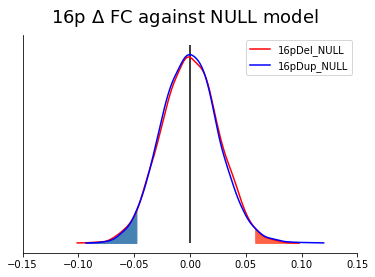

In [24]:
f = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# Plot the 16pDEL 
g_delcon = sbn.distplot(rand16_beta[0,:], hist=False, kde=True, ax=ax, label='16pDel_NULL', color='red')
g_dupcon = sbn.distplot(rand16_beta[1,:], hist=False, kde=True, ax=ax, label='16pDup_NULL', color='blue')
# Now add the area under the curve
d_delcon = g_delcon.axes.lines[0].get_data()
d_dupcon = g_dupcon.axes.lines[1].get_data()
cut_delcon = np.min(np.where(np.mean(emp16_delcon) < d_delcon[0]))
cut_dupcon = np.max(np.where(np.mean(emp16_dupcon) > d_dupcon[0]))
ax.fill_between(d_delcon[0][cut_delcon:], 0, d_delcon[1][cut_delcon:], color='tomato')
ax.fill_between(d_dupcon[0][:cut_dupcon], 0, d_dupcon[1][:cut_dupcon], color='steelblue')
ax.vlines(0, ax.get_ylim()[1], 0)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlim([-0.15, 0.15])
sbn.despine(ax=ax)
f.suptitle('16p $\Delta$ FC against NULL model', fontsize=18);
f.savefig(os.path.join(figure_p, '16p_beta_pvalues.pdf'), dpi=300, transparent=True)

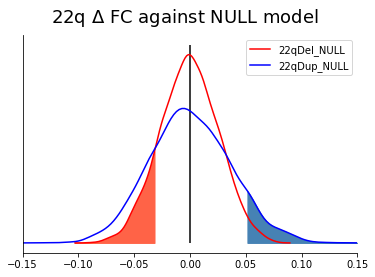

In [25]:
f = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# Plot the 16pDEL 
g_delcon = sbn.distplot(rand22_beta[0,:], hist=False, kde=True, ax=ax, label='22qDel_NULL', color='red')
g_dupcon = sbn.distplot(rand22_beta[1,:], hist=False, kde=True, ax=ax, label='22qDup_NULL', color='blue')
# Now add the area under the curve
d_delcon = g_delcon.axes.lines[0].get_data()
d_dupcon = g_dupcon.axes.lines[1].get_data()
cut_delcon = np.min(np.where(np.mean(emp22_delcon) < d_delcon[0]))
cut_dupcon = np.max(np.where(np.mean(emp22_dupcon) > d_dupcon[0]))
ax.fill_between(d_delcon[0][:cut_delcon], 0, d_delcon[1][:cut_delcon], color='tomato')
ax.fill_between(d_dupcon[0][cut_dupcon:], 0, d_dupcon[1][cut_dupcon:], color='steelblue')
ax.vlines(0, ax.get_ylim()[1], 0)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlim([-0.15, 0.15])
sbn.despine(ax=ax)
f.suptitle('22q $\Delta$ FC against NULL model', fontsize=18);
f.savefig(os.path.join(figure_p, '22q_beta_pvalues.pdf'), dpi=300, transparent=True)